Project 3: Natural Language Processing

--- Word Embeddings ---

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from os import listdir
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data import get_tokenizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
from datetime import datetime
import re

torch.manual_seed(1)

Dataset Familiarization:

In [6]:
# tokenizer will split a long text into a list of english words
tokenizer = get_tokenizer('basic_english')

def read_files(datapath='../dataset/data_train'):
    # Find all txt files in directory
    files = listdir(datapath)
    files = [datapath + "/" + f for f in files if f.endswith(".txt")]

    # Stores each line of each book in a list
    lines = []
    for f_name in files:
        with open(f_name) as f:
            lines += f.readlines()
    return lines

books_train = read_files()
books_val = read_files('../dataset/data_val')
books_test = read_files('../dataset/data_test')

# Match any word containing digit
no_digits = '\w*[0-9]+\w*'
# Match word containing a uppercase
no_names = '\w*[A-Z]+\w*'
# Match any sequence containing more than one space
no_spaces = '\s+'

def tokenize(lines):
    list_text = []
    for line in lines:
        list_text += tokenizer(line)
    return list_text

def yield_tokens(lines):
    for line in lines:
        line = re.sub(no_digits + "|" + no_names, ' ', line)
        line = re.sub(no_spaces, ' ', line)
        yield tokenizer(line)

def count_freqs(data, vocab):
    freqs = torch.zeros(len(vocab), dtype=torch.int)
    for w in data:
        freqs[vocab[w]] += 1
    return freqs

# List of words contained in the dataset
list_words_train = tokenize(books_train)
list_words_val = tokenize(books_val)
list_words_test = tokenize(books_test)

# vocab contains the vocabulary found in the data, associating an index to each word
vocab = build_vocab_from_iterator(yield_tokens(books_train), min_freq=100, specials=["<unk>"])

# Since we removed all words with an uppercase when building the vocabulary, we skipped the word "I"
vocab.append_token("i")

# Value of default index. This index will be returned when OOV (Out Of Vocabulary) token is queried.
vocab.set_default_index(vocab["<unk>"])
vocab_size = len(vocab)


print("Total number of words in the training dataset:", len(list_words_train))
print("Number of distinct words in the training dataset:", len(set(list_words_train)))
print("Number of distinct words kept in the training dataset:", vocab_size)

Total number of words in the training dataset: 1368807
Number of distinct words in the training dataset: 30374
Number of distinct words kept in the training dataset: 1050


Create Datasets With Before Word Context:

In [7]:
index2word = {}

for i in range(len(vocab)):
    index2word[i] = vocab.lookup_token(i)

In [8]:
CONTEXT_SIZE = 4
EMBEDDING_DIM = 16

def create_dataset(
    text, vocab, context_size=CONTEXT_SIZE,
):
    contexts = []
    targets = []
    n_text = len(text)

    # Transform the text as a list of integers.
    txt = [vocab[w] for w in text]

    for i in range(n_text - context_size):

        # true label = 'is the next word a known word (i.e. not '<unk>' token)?'
        if txt[i + context_size] == 0:
            continue

        t = txt[i+context_size]

        # Context before
        c = txt[i:i + context_size]

        targets.append(t)
        # Normally we should use word embedding, and not hot encoding, but we
        # skip that part for this exercise
        contexts.append(torch.tensor(c))

    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    return TensorDataset(contexts, targets)

In [9]:
data_train = create_dataset(list_words_train, vocab)
data_val = create_dataset(list_words_val, vocab)
data_test = create_dataset(list_words_test, vocab)

train_loader = DataLoader(data_train, batch_size=64, shuffle=False)
val_loader = DataLoader(data_val, batch_size=64, shuffle=False)
test_loader = DataLoader(data_test, batch_size=64, shuffle=False)

torch.save(train_loader, '../saved_sets/train.pkl')
torch.save(val_loader, '../saved_sets/val.pkl')
torch.save(test_loader, '../saved_sets/test.pkl')

In [10]:
# train_loader = torch.load('../saved_sets/train.pkl')
# val_loader = torch.load('../saved_sets/val.pkl')
# test_loader = torch.load('../saved_sets/test.pkl')

In [11]:
device = torch.device('cpu')

def train(n_epochs, optimizer, model, loss_fn, train_loader):
    n_batch = len(train_loader)
    model.train()
    losses_train = []
    optimizer.zero_grad(set_to_none=True)

    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for contexts, labels in train_loader:

            contexts = contexts.to(device=device, dtype=torch.long)
            labels = labels.to(device=device, dtype=torch.long)

            outputs = model(contexts).squeeze()

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
            datetime.now().time(), epoch, loss_train / n_batch))
    return losses_train

Define Three MLP Architectures:

In [12]:
class NGramModel1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_size):
        super(NGramModel1, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 64)
        self.linear2 = nn.Linear(64, 96)
        self.linear3 = nn.Linear(96, 128)
        self.linear4 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        embeds = torch.flatten(embeds, 1)
        out = F.relu(self.linear1(embeds))
        out = F.relu(self.linear2(out))
        out = F.relu(self.linear3(out))
        out = self.linear4(out)
        return out

In [21]:
class NGramModel2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_size):
        super(NGramModel2, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 64)
        self.linear2 = nn.Linear(64, 48)
        self.linear3 = nn.Linear(48, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        embeds = torch.flatten(embeds, 1)
        out = F.relu(self.linear1(embeds))
        out = F.relu(self.linear2(out))
        out = self.linear3(out)
        return out

In [22]:
class NGramModel3(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_size):
        super(NGramModel3, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 32)
        self.linear2 = nn.Linear(32, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        embeds = torch.flatten(embeds, 1)
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        return out

In [15]:
# Model parameters
EPOCHS = 5  # Epochs
BATCH_SIZE = 64  # Batch size  // Not used yet

#Optimizer parameters
LR = 1e-3  # Learning Rate
BETAS = (0.9, 0.999)  # ADAM Momentum and RSMProp Betas
EPSILON = 1e-8  # ADAM Vanishing and Exploding Gradients
LAMBDA = 1e-8  # L2 Regularization

# Not used in the model
SHALLOW_HIDDEN_SIZE = 32
MIDDLE_HIDDEN_SIZE = 48
DEEP_HIDDEN_SIZE = 64

Train Word Embeddings Selecting The Best Model:

In [16]:
models, model_names, losses = [], [], []

In [17]:
loss_function = nn.CrossEntropyLoss()
model1 = NGramModel1(vocab_size, EMBEDDING_DIM, CONTEXT_SIZE, DEEP_HIDDEN_SIZE)

optimizer = optim.RAdam(model1.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)

loss = train(
    EPOCHS,
    optimizer,
    model1,
    loss_function,
    train_loader
)

models.append(model1)
model_names.append("DEEP MODEL")
losses.append(loss)

12:14:21.858582  |  Epoch 1  |  Training loss 4.28950
12:15:35.515551  |  Epoch 2  |  Training loss 4.01019
12:16:56.233934  |  Epoch 3  |  Training loss 3.95965
12:18:44.210070  |  Epoch 4  |  Training loss 3.93537
12:20:43.574178  |  Epoch 5  |  Training loss 3.92089


In [23]:
loss_function = nn.CrossEntropyLoss()
model2 = NGramModel2(vocab_size, EMBEDDING_DIM, CONTEXT_SIZE, MIDDLE_HIDDEN_SIZE)

optimizer = optim.RAdam(model2.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)

loss = train(
    EPOCHS,
    optimizer,
    model2,
    loss_function,
    train_loader
)

models.append(model2)
model_names.append("MIDDLE MODEL")
losses.append(loss)

12:24:27.563785  |  Epoch 1  |  Training loss 4.35928
12:25:36.150316  |  Epoch 2  |  Training loss 4.04525
12:26:33.219255  |  Epoch 3  |  Training loss 3.98653
12:27:42.980732  |  Epoch 4  |  Training loss 3.95924
12:28:45.328347  |  Epoch 5  |  Training loss 3.94346


In [24]:
loss_function = nn.CrossEntropyLoss()
model3 = NGramModel3(vocab_size, EMBEDDING_DIM, CONTEXT_SIZE, MIDDLE_HIDDEN_SIZE)

optimizer = optim.RAdam(model3.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)

loss = train(
    EPOCHS,
    optimizer,
    model3,
    loss_function,
    train_loader
)

models.append(model3)
model_names.append("SHALLOW MODEL")
losses.append(loss)

12:29:40.828641  |  Epoch 1  |  Training loss 4.44506
12:30:37.319830  |  Epoch 2  |  Training loss 4.09581
12:31:24.150869  |  Epoch 3  |  Training loss 4.04229
12:32:04.675472  |  Epoch 4  |  Training loss 4.01979
12:32:44.681626  |  Epoch 5  |  Training loss 4.00795


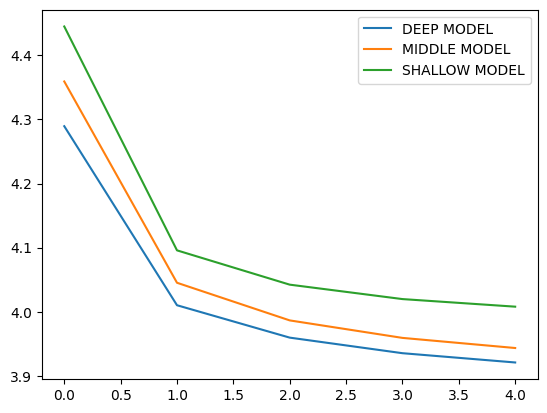

In [25]:
for i, e in zip(losses, model_names):
    plt.plot(i, label=e)
    plt.legend()
plt.show()

In [26]:
def compute_accuracy(model, loader):
    correct = 0.
    total = 0.
    with torch.no_grad():
        for contexts, labels in loader:
            contexts = contexts.to(device=device)
            labels = labels.to(device=device)

            outputs = model(contexts)
            _, predicted = torch.max(outputs, dim=1)
            total += BATCH_SIZE
            correct += int((predicted == labels).sum())

    acc =  correct / total
    return acc

In [27]:
def find_best_model(loader):
    max_accuracy = 0
    best_model = 0
    for i in range(len(models)):
        model_accuracy = round(compute_accuracy(models[i], loader) * 100)

        if model_accuracy > max_accuracy:
            max_accuracy = model_accuracy
            best_model = i

    print("Best model is:", model_names[best_model])

    return models[best_model]

In [28]:
best_model_emd = find_best_model(val_loader)

Best model is: DEEP MODEL


In [29]:
print("Test set accuracy of the best model is " + str(round(compute_accuracy(best_model_emd, test_loader) * 100, 2)) + "%")

Test set accuracy of the best model is 18.29%


Calculate Cosine Similarity For Word Similarity:

In [54]:
cos = nn.CosineSimilarity(dim=1, eps=EPSILON)
embd_weights = best_model_emd.embeddings.weight
cosineSimilarityMatrix = [[0 for i in range(embd_weights.shape[0])] for j in range(embd_weights.shape[0])]

for i in range(embd_weights.shape[0]):
    for j in range(embd_weights.shape[0]):
        cosineSimilarityMatrix[i][j] = F.cosine_similarity(embd_weights[i], embd_weights[j], dim=0).item()

words_displayed = 10
for i in range(len(cosineSimilarityMatrix)):
    for j in range(len(cosineSimilarityMatrix[0])):
        if i == 0 or j == 0:
                continue
        elif 0.8 < cosineSimilarityMatrix[i][j] < 1.0:  # Describes how equal two vectors are and should be increased with more precise embeddings
            if words_displayed < 10:
                print("\'" + index2word[i] + "\'" + " is similar to " +  "\'" + index2word[j] + "\'")
                words_displayed += 1
            else:
                break

Display and Storing of Similar Words (embedd.tsv)

In [31]:
import pandas as pd
var = vocab.to()
voc_dict = var.vocab.get_stoi()
vocab_list = [x for x in voc_dict.keys()]
df = pd.DataFrame(vocab_list).to_csv('../website/vocab.tsv', header=False, index=False, sep="\t")

In [32]:
track = []
for word in range(len(vocab_list)):
    ind = torch.tensor(word, dtype=torch.int).cpu()
    emb = best_model_emd.embeddings(ind)
    track.append(emb.tolist())
df2 = pd.DataFrame(track).to_csv('../website/embedd.tsv', header=False, index=False, sep="\t")

--- RNN vs MLP Comparison ---

Create Datasets With Between Context For Conjugates:

In [33]:
conjugations = ['am', 'are', 'is', 'has', 'were', 'was', 'being', 'been','be', 'have', 'had', 'having']

CONTEXT_SIZE = 4
EMBEDDING_DIM = 16

conj_vocab = {}
for i in range(len(conjugations)):
    conj_vocab[vocab[conjugations[i]]] = i

def create_dataset_between(
    text, vocab, context_size=2,
):
    contexts = []
    targets = []
    n_text = len(text)

    # Transform the text as a list of integers.
    txt = [vocab[w] for w in text]

    for i in range(1, n_text - context_size - 2):

        # true label = 'is the next word a known word (i.e. not '<unk>' token)?'
        if txt[i] == 0 or index2word[txt[i]] not in conjugations:
            continue

        t = conj_vocab[txt[i]]

        # Context before/after
        # c = [txt[i - 1]] + [txt[i + 1]]
        c = txt[i - int(CONTEXT_SIZE / 2) :i] + txt[i + 1 : i + 1 + int(CONTEXT_SIZE / 2)]

        targets.append(t)
        # Normally we should use word embedding, and not hot encoding, but we
        # skip that part for this exercise
        contexts.append(torch.tensor(c))

    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    return TensorDataset(contexts, targets)

data_train_between = create_dataset_between(list_words_train, vocab)
data_val_between = create_dataset_between(list_words_val, vocab)
data_test_between = create_dataset_between(list_words_test, vocab)

In [34]:
train_loader_between = DataLoader(data_train_between, batch_size=64, shuffle=False)
val_loader_between = DataLoader(data_val_between, batch_size=64, shuffle=False)
test_loader_between = DataLoader(data_test_between, batch_size=64, shuffle=False)

Define Two MLP Models and Two RNN Models:

In [35]:
class MLP1(nn.Module):
  def __init__(self, embedding_dim, context_size, num_classes, hidden_size):
    super(MLP1, self).__init__()
    self.embeddings = best_model_emd.embeddings
    #self.embeddings = nn.Embedding.from_pretrained(best_model_emd.embeddings, freeze=True)
    self.linear1 = nn.Linear(context_size * embedding_dim, 64)
    self.linear2 = nn.Linear(64, 96)
    self.linear3 = nn.Linear(96, 128)
    self.output = nn.Linear(128, num_classes)

  def forward(self, x):
    embeds = self.embeddings(x)
    embeds = torch.flatten(embeds, 1)
    out = F.relu(self.linear1(embeds))
    out = F.relu(self.linear2(out))
    out = F.relu(self.linear3(out))
    out = self.output(out)
    return out

In [36]:
class RNN1(nn.Module):
    def __init__(self, embedding_dim, num_classes, hidden_size, num_layers):
        super(RNN1, self).__init__()
        self.embeddings = best_model_emd.embeddings
        #self.embeddings = nn.Embedding.from_pretrained(best_model_emd.embeddings, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=hidden_size, batch_first=True, num_layers=num_layers)
        self.output = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embeds = self.embeddings(x)
        out, (h_n, c_n) = self.lstm(embeds)
        out = self.output(h_n[-1])
        return out

In [37]:
class MLP2(nn.Module):
  def __init__(self, embedding_dim, context_size, num_classes, hidden_size):
    super(MLP2, self).__init__()
    self.embeddings = best_model_emd.embeddings
    #self.embeddings = nn.Embedding.from_pretrained(best_model_emd.embeddings, freeze=True)
    self.linear = nn.Linear(context_size * embedding_dim, hidden_size)
    self.output = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    embeds = self.embeddings(x)
    embeds = torch.flatten(embeds, 1)
    out = F.relu(self.linear(embeds))
    out = self.output(out)
    return out

In [38]:
class RNN2(nn.Module):
    def __init__(self, embedding_dim, num_classes, hidden_size, num_layers):
        super(RNN2, self).__init__()
        self.embeddings = best_model_emd.embeddings
        #self.embeddings = nn.Embedding.from_pretrained(best_model_emd.embeddings, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=hidden_size, batch_first=True, num_layers=num_layers)
        self.output = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embeds = self.embeddings(x)
        out, (h_n, c_n) = self.lstm(embeds)
        out = self.output(h_n[-1])
        return out

In [39]:
# Model parameters
EPOCHS = 5  # Epochs
BATCH_SIZE = 64  # Batch size  // Not used yet

#Optimizer parameters
LR = 1e-3  # Learning Rate
BETAS = (0.9, 0.999)  # ADAM Momentum and RSMProp Betas
EPSILON = 1e-8  # ADAM Vanishing and Exploding Gradients
LAMBDA = 1e-8  # L2 Regularization

MLP_SHALLOW_HIDDEN_SIZE = 32
MLP_DEEP_HIDDEN_SIZE = 64

RNN_DEEP_HIDDEN_SIZE = 128
NUMBER_OF_LAYERS_DEEP = 3

RNN_SHALLOW_HIDDEN_SIZE = 32
NUMBER_OF_LAYERS_SHALLOW = 1

models, model_names, losses, time_mlp, time_rnn = [], [], [], [], []

Train Models Selecting The Best:

In [40]:
loss_function = nn.CrossEntropyLoss()

model1 = MLP1(EMBEDDING_DIM, CONTEXT_SIZE, len(conjugations), DEEP_HIDDEN_SIZE)
optimizer = optim.RAdam(model1.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)
star_time = time.time()
loss = train(
    EPOCHS,
    optimizer,
    model1,
    loss_function,
    train_loader_between
)
time_mlp.append(time.time() - star_time)
models.append(model1)
model_names.append("Deep MLP")
losses.append(loss)

12:33:48.853806  |  Epoch 1  |  Training loss 1.59362
12:33:51.305908  |  Epoch 2  |  Training loss 1.19726
12:33:53.641268  |  Epoch 3  |  Training loss 1.09676
12:33:55.950599  |  Epoch 4  |  Training loss 1.04242
12:33:58.450649  |  Epoch 5  |  Training loss 1.00574


In [41]:
loss_function = nn.CrossEntropyLoss()

model2 = RNN1(EMBEDDING_DIM, len(conjugations), DEEP_HIDDEN_SIZE, NUMBER_OF_LAYERS_DEEP)
optimizer = optim.RAdam(model2.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)
star_time = time.time()
loss = train(
    EPOCHS,
    optimizer,
    model2,
    loss_function,
    train_loader_between
)
time_rnn.append(time.time() - star_time)
models.append(model2)
model_names.append("Deep RNN")
losses.append(loss)

12:34:07.684953  |  Epoch 1  |  Training loss 1.67653
12:34:17.464132  |  Epoch 2  |  Training loss 1.17070
12:34:27.775851  |  Epoch 3  |  Training loss 1.08045
12:34:35.803263  |  Epoch 4  |  Training loss 1.03376
12:34:47.164857  |  Epoch 5  |  Training loss 1.00224


In [42]:
loss_function = nn.CrossEntropyLoss()

model3 = MLP2(EMBEDDING_DIM, CONTEXT_SIZE, len(conjugations), SHALLOW_HIDDEN_SIZE)
optimizer = optim.RAdam(model3.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)
star_time = time.time()
loss = train(
    EPOCHS,
    optimizer,
    model3,
    loss_function,
    train_loader_between
)
time_mlp.append(time.time() - star_time)
models.append(model3)
model_names.append("SHALLOW MLP")
losses.append(loss)

12:34:49.212071  |  Epoch 1  |  Training loss 1.64961
12:34:51.837932  |  Epoch 2  |  Training loss 1.10069
12:34:54.675107  |  Epoch 3  |  Training loss 1.03457
12:34:57.291879  |  Epoch 4  |  Training loss 1.00717
12:34:59.478250  |  Epoch 5  |  Training loss 0.98906


In [43]:
loss_function = nn.CrossEntropyLoss()

model4 = RNN2(EMBEDDING_DIM, len(conjugations), SHALLOW_HIDDEN_SIZE, NUMBER_OF_LAYERS_SHALLOW)
optimizer = optim.RAdam(model4.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)
star_time = time.time()
loss = train(
    EPOCHS,
    optimizer,
    model4,
    loss_function,
    train_loader_between
)
time_rnn.append(time.time() - star_time)
models.append(model4)
model_names.append("SHALLOW RNN")
losses.append(loss)

12:35:03.750271  |  Epoch 1  |  Training loss 1.76667
12:35:08.083676  |  Epoch 2  |  Training loss 1.14999
12:35:11.237101  |  Epoch 3  |  Training loss 1.07085
12:35:14.534116  |  Epoch 4  |  Training loss 1.03164
12:35:18.940687  |  Epoch 5  |  Training loss 1.00692


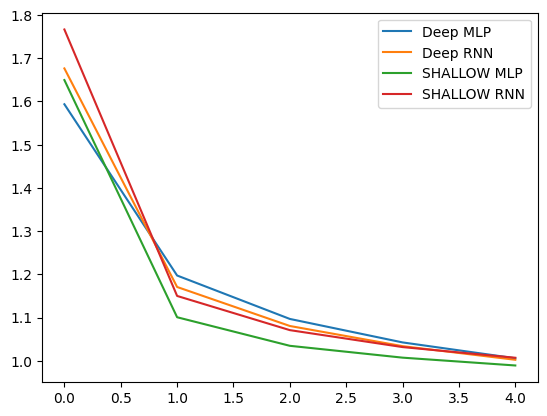

In [44]:
for i, e in zip(losses, model_names):
    plt.plot(i, label=e)
    plt.legend()
plt.show()

In [45]:
best_model = find_best_model(val_loader_between)

Best model is: SHALLOW MLP


In [46]:
print("Test set accuracy of the best model is " + str(round(compute_accuracy(best_model, test_loader_between) * 100, 2)) + "%")

Test set accuracy of the best model is 43.49%


Compare Time Spent Training:

In [47]:
avg_time_mlp = 0
avg_time_rnn = 0
for i in range(len(time_mlp)):
    avg_time_mlp += time_mlp[i]
    avg_time_rnn += time_rnn[i]

print("Avrage time training MLP:", round(avg_time_mlp / len(time_mlp), 2), "seconds vs average time training RNN", round(avg_time_rnn / len(time_rnn), 2),"seconds")

Avrage time training MLP: 12.2 seconds vs average time training RNN 34.08 seconds


--- Text Generation ---

Load New Dataset With Before Word Context:

In [55]:
train_loader = DataLoader(data_train, batch_size=64, shuffle=True)
val_loader = DataLoader(data_val, batch_size=64, shuffle=True)
test_loader = DataLoader(data_test, batch_size=64, shuffle=True)

Define Two RNN Models:

In [56]:
class RNN1(nn.Module):

    def __init__(self, embedding_dim, num_classes, hidden_size, num_layers):
        super(RNN1, self).__init__()
        self.embeddings = best_model_emd.embeddings
        #self.embeddings = nn.Embedding.from_pretrained(best_model_emd.embeddings, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=hidden_size, batch_first=True, num_layers=num_layers)
        self.output = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embeds = self.embeddings(x)
        out, (h_n, c_n) = self.lstm(embeds)
        out = self.output(h_n[-1])
        return out

In [57]:
class RNN2(nn.Module):

    def __init__(self, embedding_dim, num_classes, hidden_size, num_layers):
        super(RNN2, self).__init__()
        self.embeddings = best_model_emd.embeddings
        #self.embeddings = nn.Embedding.from_pretrained(best_model_emd.embeddings, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=hidden_size, batch_first=True, num_layers=num_layers)
        self.output = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embeds = self.embeddings(x)
        out, (h_n, c_n) = self.lstm(embeds)
        out = self.output(h_n[-1])
        return out

In [58]:
CONTEXT_SIZE = 4
EMBEDDING_DIM = 16

# Model parameters
EPOCHS = 5  # Epochs
BATCH_SIZE = 64  # Batch size  // Not used yet

#Optimizer parameters
LR = 1e-2  # Learning Rate
BETAS = (0.9, 0.999)  # ADAM Momentum and RSMProp Betas
EPSILON = 1e-8  # ADAM Vanishing and Exploding Gradients
LAMBDA = 1e-16  # L2 Regularization

SHALLOW_HIDDEN_SIZE = 24
DEEP_HIDDEN_SIZE = 96

NUMBER_OF_LAYERS_DEEP = 3
NUMBER_OF_LAYERS_SHALLOW = 1

models, model_names, losses_train = [], [], []

Train The Models Selecting The Best:

In [59]:
loss_function = nn.CrossEntropyLoss()

model1 = RNN1(EMBEDDING_DIM, vocab_size, DEEP_HIDDEN_SIZE, NUMBER_OF_LAYERS_DEEP)
optimizer = optim.RAdam(model1.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)
loss = train(
    EPOCHS,
    optimizer,
    model1,
    loss_function,
    train_loader
)

models.append(model1)
model_names.append("DEEP RNN")
losses_train.append(loss)

12:43:38.177665  |  Epoch 1  |  Training loss 4.19105
12:47:38.320101  |  Epoch 2  |  Training loss 3.99082
12:52:47.099198  |  Epoch 3  |  Training loss 3.93899
13:00:21.569634  |  Epoch 4  |  Training loss 3.90814
13:09:55.246468  |  Epoch 5  |  Training loss 3.88985


In [60]:
loss_function = nn.CrossEntropyLoss()

model2 = RNN2(EMBEDDING_DIM, vocab_size, SHALLOW_HIDDEN_SIZE, NUMBER_OF_LAYERS_SHALLOW)
optimizer = optim.RAdam(model2.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)
loss = train(
    EPOCHS,
    optimizer,
    model2,
    loss_function,
    train_loader
)

models.append(model2)
model_names.append("SHALLOW RNN")
losses_train.append(loss)

13:10:57.818132  |  Epoch 1  |  Training loss 4.26809
13:12:00.505101  |  Epoch 2  |  Training loss 4.15967
13:13:03.297788  |  Epoch 3  |  Training loss 4.14686
13:14:14.989323  |  Epoch 4  |  Training loss 4.14369
13:15:29.830141  |  Epoch 5  |  Training loss 4.14200


In [61]:
best_model = find_best_model(val_loader)

Best model is: SHALLOW RNN


In [62]:
print("Test set accuracy of the best model is " + str(round(compute_accuracy(best_model, test_loader) * 100, 2)) + "%")

Test set accuracy of the best model is 18.04%


Beam Search Algorithm For Word Selection:

In [63]:
def getRandomText(text,length, beam_size):
    txt = text.lower().split()

     # Transform the text as a list of integers.
    text_as_indices = [vocab[w] for w in txt]

    beams = [(text_as_indices, -100.0)]
    for _ in range(length):
        new_beams = []
        for beam in beams:
            model_output = torch.log_softmax(best_model(torch.tensor(beam[0])), dim=0)  # Log gives negative values [0, 1)
            top_k = torch.topk(model_output, beam_size, dim=0)
            values, indices = top_k.values, top_k.indices

            for i in range(len(values)):
                new_beam = beam[0].copy()
                word_as_indices = indices[i].item()
                prob = values[i].item()

                new_beam.append(word_as_indices)
                new_beams.append((new_beam, prob))

        new_beams = sorted(new_beams, key=lambda x : x[1], reverse=True)
        beams = new_beams[:3]

    return ' '.join([index2word[w] for w in beams[0][0]])

Text Generation Examples:

In [64]:
getRandomText("Sir arrived at noon with train and was happy", 6, 3)

'sir arrived at <unk> with train and was happy to do . i am sure'

In [65]:
getRandomText("A dream", 2, 3)

'a dream of the'

In [66]:
getRandomText("I have a dream a world where ", 20, 7)

'i have a dream a world where she had returned to the door , and the door of his face , and the old prince had been'

In [67]:
getRandomText("I have a dream that one day on the red hills of Georgia, the sons of former slaves and the sons of former slave owners will be able to sit down together at the table of brotherhood.", 30, 5)

'i have a dream that one day on the red <unk> of <unk> the <unk> of former <unk> and the <unk> of former <unk> <unk> will be able to sit down together at the table of <unk> . he had returned to the door , and the door of his face , and the old prince had been to see him , and he had returned to'